## Read population data from folder population_data, join tables and create and save annual figures

#### Import libraries

In [135]:
# Import libraries
from pyproj import CRS
import geopandas as gpd
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Turhia ???

#import geojson
#import mplleaflet
#import folium
#import re
#import contextily as ctx
#from pyproj import CRS
#from geopandas.tools import geocode
#from shapely.geometry import Point, Polygon
#import requests

#### Read population shape files

In [136]:
def read_population_data(year):
    
    # Define path to file
    fp = "population_data/"+str(year)+"/Vaestotietoruudukko_"+str(year)+".shp"
    
    # Read shapefile
    pop = gpd.read_file(fp)
    
    # Define coordinate reference system
    pop.crs = CRS.from_epsg(3879).to_wkt()
    
    # Drop columns if number of resudents is less than 0 (no value) or over 15000 (values without real location)
    pop = pop[(pop["ASUKKAITA"] > 0) & (pop["ASUKKAITA"] < 15000)]
    
    # Drop all the columns except index and asukkaita
    pop_pop = pop[["INDEX", "ASUKKAITA"]]
    pop_geom = pop[["INDEX", "geometry"]]
    
    # Print number of residents by year
    print(year, "number of residents:", pop_pop["ASUKKAITA"].sum())
    
    # Split data to two parts for later joining. First will have population data and second geometric data.
    
    # Rename column asukkaita to pop+year
    pop_pop = pop_pop.rename(columns={'ASUKKAITA': 'pop'+str(year)})
    
    # Rename column geometry to geometry+year. Must do to later fill missing values and merge tables.
    pop_geom = pop_geom.rename(columns={'geometry': 'geometry'+str(year)})
    
    # Set column INDEX to INDEX
    pop_pop = pop_pop.set_index("INDEX")
    pop_geom = pop_geom.set_index("INDEX")
    
    # Return result geodataframe
    return pop_pop, pop_geom

#### Read the files

In [137]:
# Data is available from years 1997-2003 and 2008-2019

# Years 1997 to 2003
pop1997_pop, pop1997_geom = read_population_data(1997)
pop1998_pop, pop1998_geom = read_population_data(1998)
pop1999_pop, pop1999_geom = read_population_data(1999)
pop2000_pop, pop2000_geom = read_population_data(2000)
pop2001_pop, pop2001_geom = read_population_data(2001)
pop2002_pop, pop2002_geom = read_population_data(2002)
pop2003_pop, pop2003_geom = read_population_data(2003)

# Years 2008 to 2012
pop2008_pop, pop2008_geom = read_population_data(2008)
pop2009_pop, pop2009_geom = read_population_data(2009)
pop2010_pop, pop2010_geom = read_population_data(2010)
pop2011_pop, pop2011_geom = read_population_data(2011)
pop2012_pop, pop2012_geom = read_population_data(2012)

# Years 2013 to 2019
pop2013_pop, pop2013_geom = read_population_data(2013)
pop2014_pop, pop2014_geom = read_population_data(2014)
pop2015_pop, pop2015_geom = read_population_data(2015)
pop2016_pop, pop2016_geom = read_population_data(2016)
pop2017_pop, pop2017_geom = read_population_data(2017)
pop2018_pop, pop2018_geom = read_population_data(2018)
pop2019_pop, pop2019_geom = read_population_data(2019)

1997 number of residents: 882280
1998 number of residents: 894264
1999 number of residents: 909602
2000 number of residents: 919561
2001 number of residents: 925631
2002 number of residents: 938930
2003 number of residents: 943607
2008 number of residents: 979739
2009 number of residents: 1007910
2010 number of residents: 1012326
2011 number of residents: 1025560
2012 number of residents: 1036528
2013 number of residents: 1049988
2014 number of residents: 1076765
2015 number of residents: 1087308
2016 number of residents: 1111940
2017 number of residents: 1121567
2018 number of residents: 1137053
2019 number of residents: 1155285


## Join tables and save results

#### Hox! Between years 1997 and 2012 grid size 500m x 500m. Since 2013 grid size 250m x 250m. Thats why will create two different geodataframes.

#### First create years 1997 to 2012.

In [138]:
# Combine dataframes to lists
pop_list = [pop1997_pop, pop1998_pop, pop1999_pop, pop2000_pop, pop2001_pop, pop2002_pop, pop2003_pop,
           pop2008_pop, pop2009_pop, pop2010_pop, pop2011_pop, pop2012_pop]

geom_list = [pop1997_geom, pop1998_geom, pop1999_geom, pop2000_geom, pop2001_geom, pop2002_geom, pop2003_geom,
           pop2008_geom, pop2009_geom, pop2010_geom, pop2011_geom, pop2012_geom]

# Merge dataframes
pop = reduce(lambda left,right: pd.merge(left,right,on='INDEX', how="outer"), pop_list)
geom = reduce(lambda left,right: pd.merge(left,right,on='INDEX', how="outer"), geom_list)

# Fill missing population values with 0
pop = pop.fillna(0)

# Fill missing geometry value from left
geom["geometry"] = geom.apply(lambda x:  x[x.last_valid_index()], axis=1)
geom = geom["geometry"]

# Merge dataframes pop and geom
population = pop.join(geom)

# Convert dataframe back to geodataframe
population1997to2012 = gpd.GeoDataFrame(population)

# Set coordinate reference system
population1997to2012.crs = CRS.from_epsg(3879).to_wkt()

# Save geodataframe
outfp = "population_data/population1997to2012.shp"
population1997to2012.to_file(outfp)

# Show 3 first row
population1997to2012.head(3)

# Print largest values in cell
# population1997to2012.nlargest(5, 'pop2001')

pop1997  pop1998  pop1999  pop2000  pop2001  pop2002  pop2003  pop2008  \
INDEX                                                                           
14        55.0     52.0     79.0     84.0     50.0     49.0     47.0     49.0   
16        25.0     29.0     20.0     23.0     33.0     35.0     34.0     38.0   
17        13.0     13.0      0.0      0.0     12.0     12.0     12.0      0.0   

       pop2009  pop2010  pop2011  pop2012  \
INDEX                                       
14        55.0     54.0     51.0     50.0   
16        38.0     38.0     36.0     32.0   
17         0.0      0.0      0.0      0.0   

                                                geometry  
INDEX                                                     
14     POLYGON Z ((25488999.996 6695499.995 0.000, 25...  
16     POLYGON Z ((25491000.002 6695499.995 0.000, 25...  
17     POLYGON Z ((25492000.001 6695499.995 0.000, 25...

#### Then create years 2013 to 2019

In [139]:
# Combine dataframes to lists
pop_list = [pop2013_pop, pop2014_pop, pop2015_pop, pop2016_pop, pop2017_pop, pop2018_pop, pop2019_pop]
geom_list = [pop2013_geom, pop2014_geom, pop2015_geom, pop2016_geom, pop2017_geom, pop2018_geom, pop2019_geom]

# Merge dataframes
pop = reduce(lambda left,right: pd.merge(left,right,on='INDEX', how="outer"), pop_list)
geom = reduce(lambda left,right: pd.merge(left,right,on='INDEX', how="outer"), geom_list)

# Fill missing population values with 0
pop = pop.fillna(0)

# Fill missing geometry value from left
geom["geometry"] = geom.apply(lambda x:  x[x.last_valid_index()], axis=1)
geom = geom["geometry"]

# Merge dataframes pop and geom
population = pop.join(geom)

# Convert dataframe back to geodataframe
population2013to2019 = gpd.GeoDataFrame(population)

# Set coordinate reference system
population2013to2019.crs = CRS.from_epsg(3879).to_wkt()

# Save geodataframe
outfp = "population_data/population1997to2012.shp"
population1997to2012.to_file(outfp)

# Show 3 first row
population2013to2019.head(3)

pop2013  pop2014  pop2015  pop2016  pop2017  pop2018  pop2019  \
INDEX                                                                  
688        5.0      8.0      8.0      7.0      9.0      9.0      0.0   
703        6.0      6.0      6.0      6.0      0.0      5.0      5.0   
710        7.0      8.0      8.0      8.0      8.0      8.0      8.0   

                                                geometry  
INDEX                                                     
688    POLYGON Z ((25472499.995 6689749.005 0.000, 25...  
703    POLYGON Z ((25472499.995 6685998.998 0.000, 25...  
710    POLYGON Z ((25472499.995 6684249.004 0.000, 25...

## Visualize results

#### First select dataframes and parameters in visualization

In [140]:
# Select geodataframe
gdf = population1997to2012
#gdf = population2013to2019

# Select years list
years = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2008, 2009, 2010, 2011, 2012]
#years = [2013, 2014, 2015, 2016, 2017, 2018, 2019]

# Select colour map range. Before 2013 grid size 500m x 500m and since 2013 grid size 250m x 250m.
max_population = 10000 # Use with data before 2013
#max_population = 2500 # Use with data since 2013

#### Visualize tables

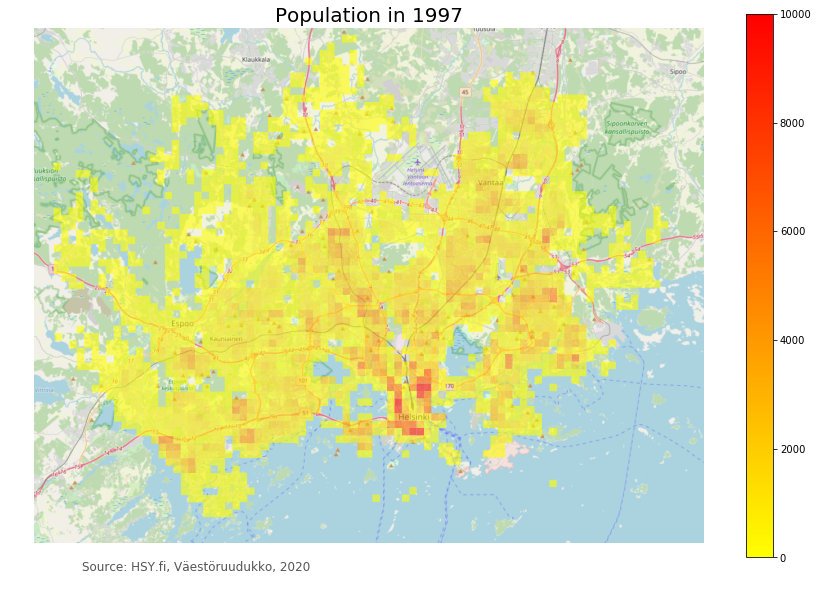

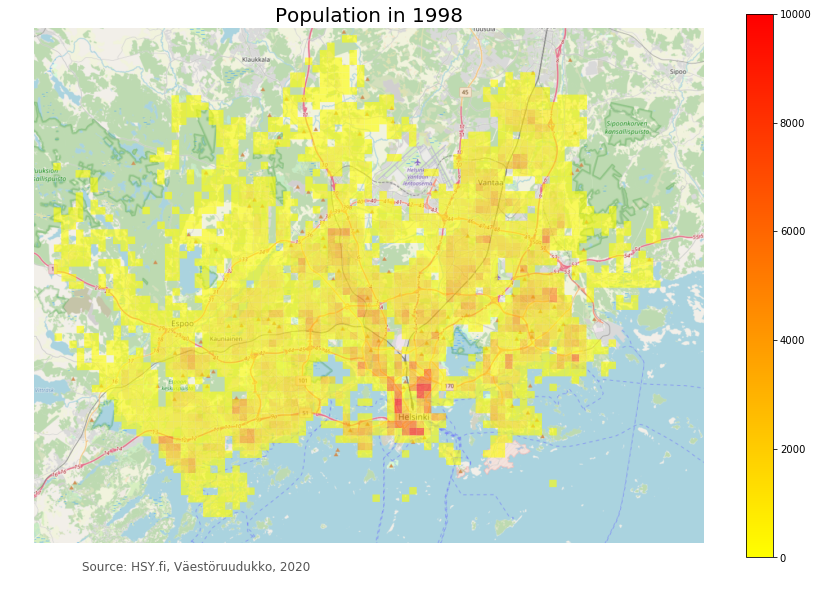

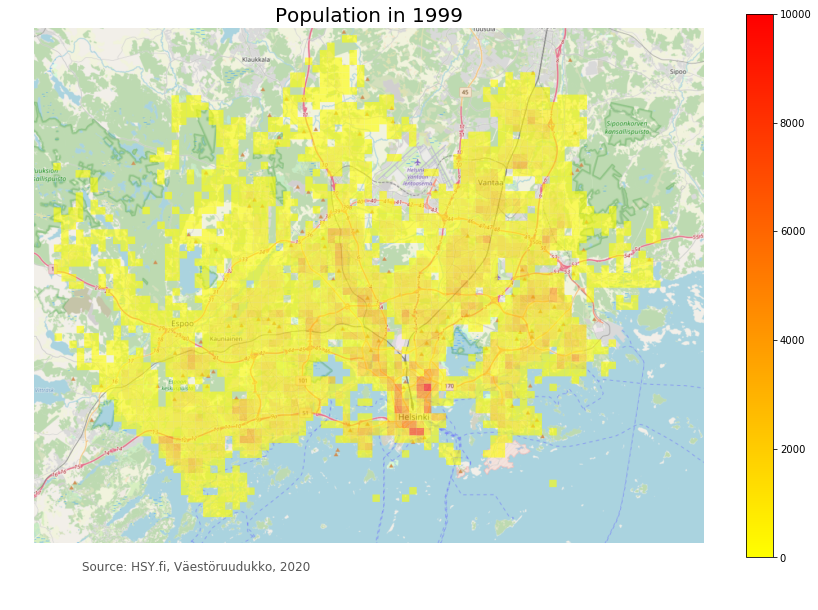

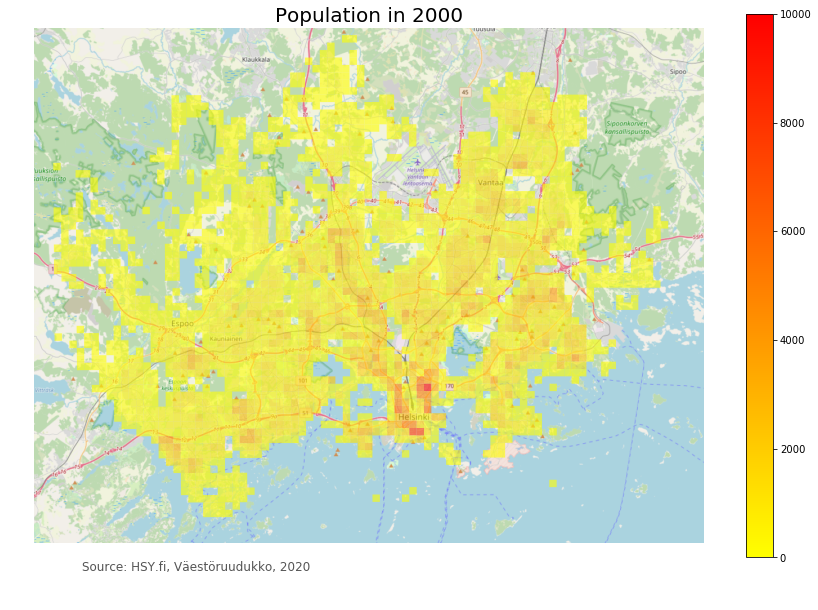

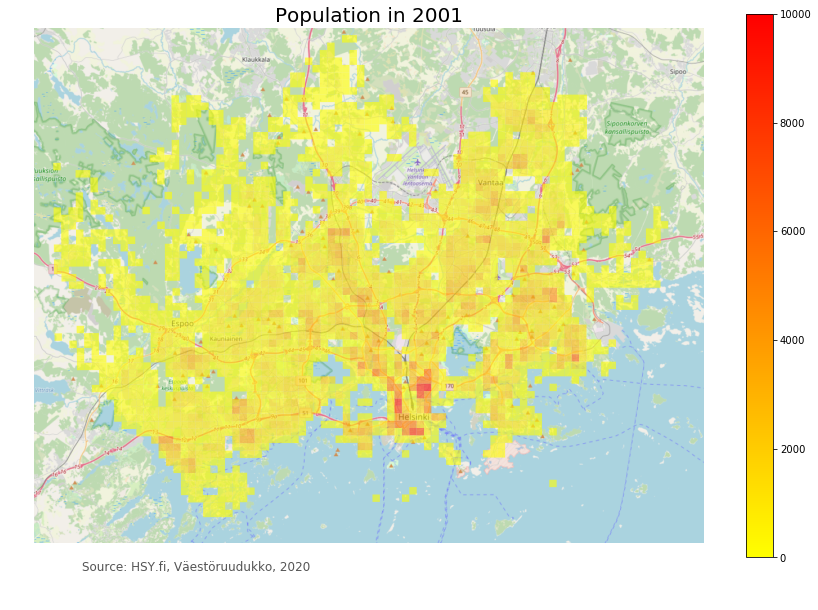

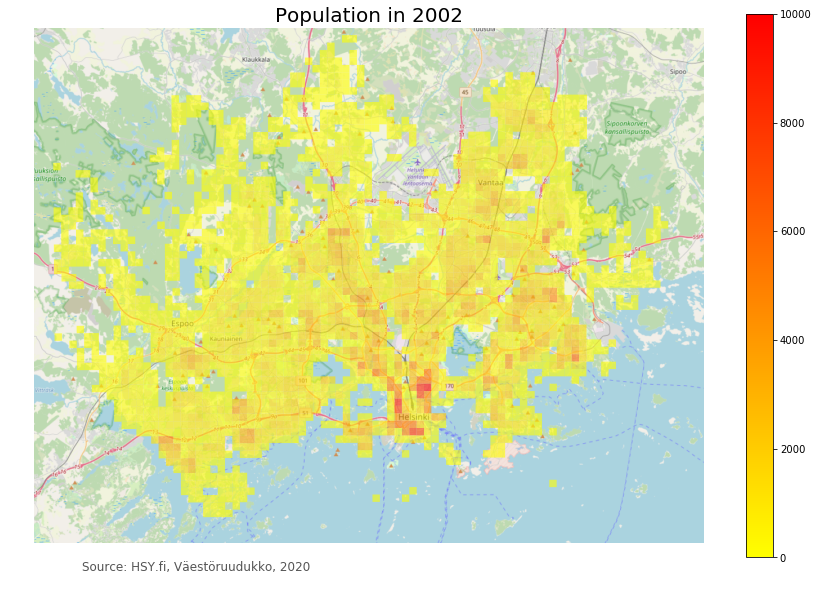

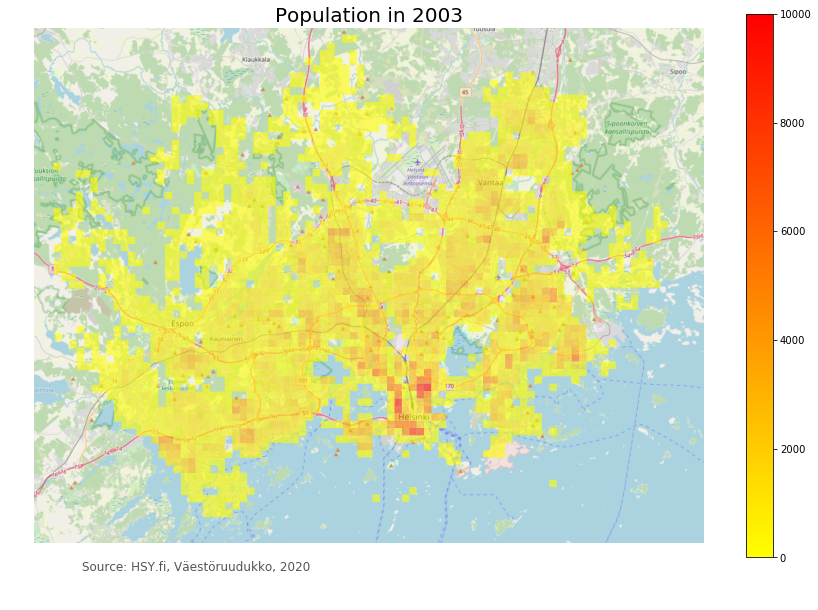

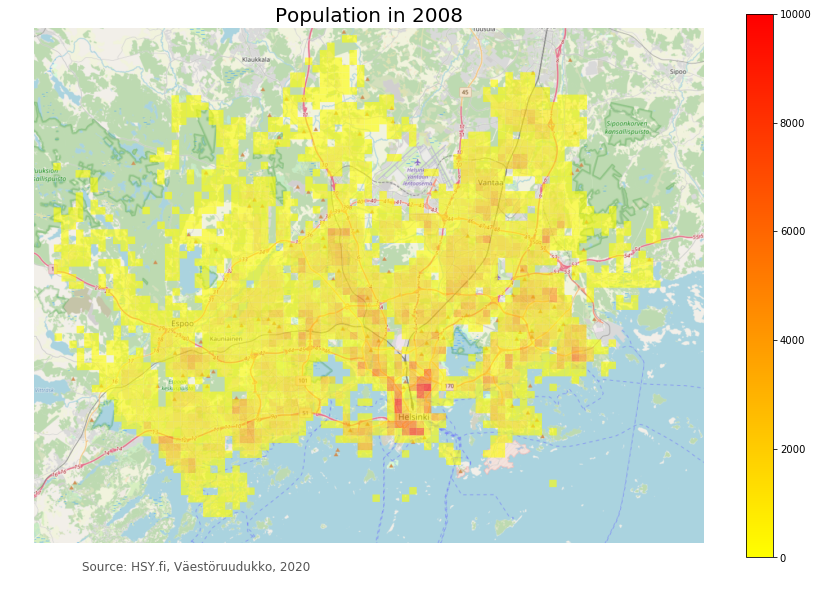

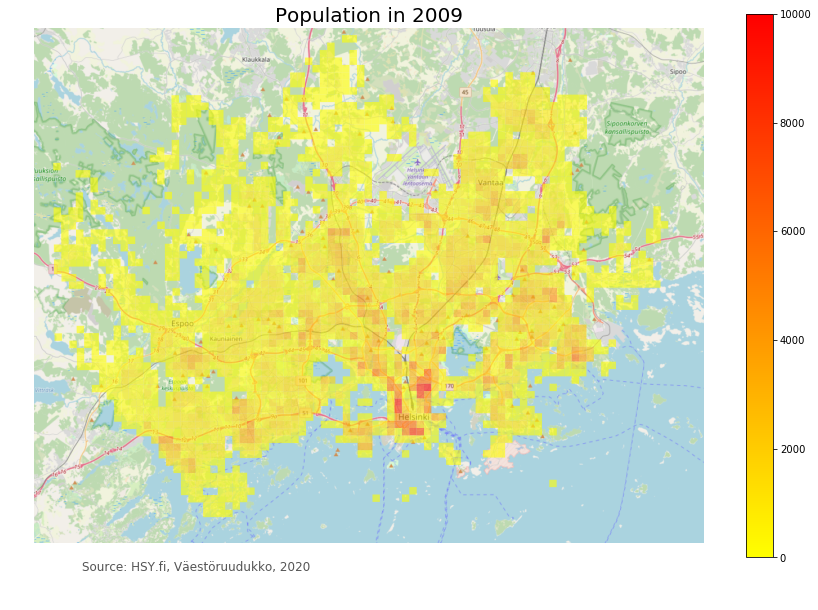

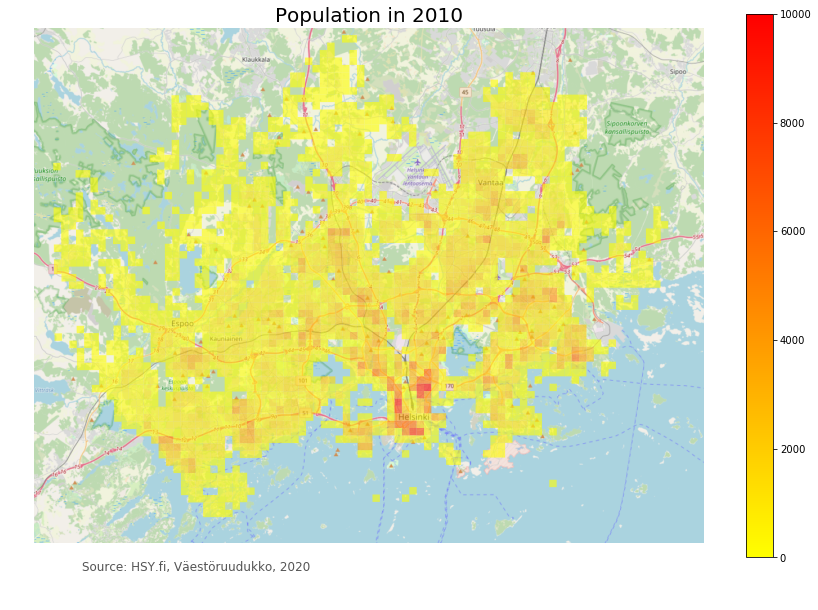

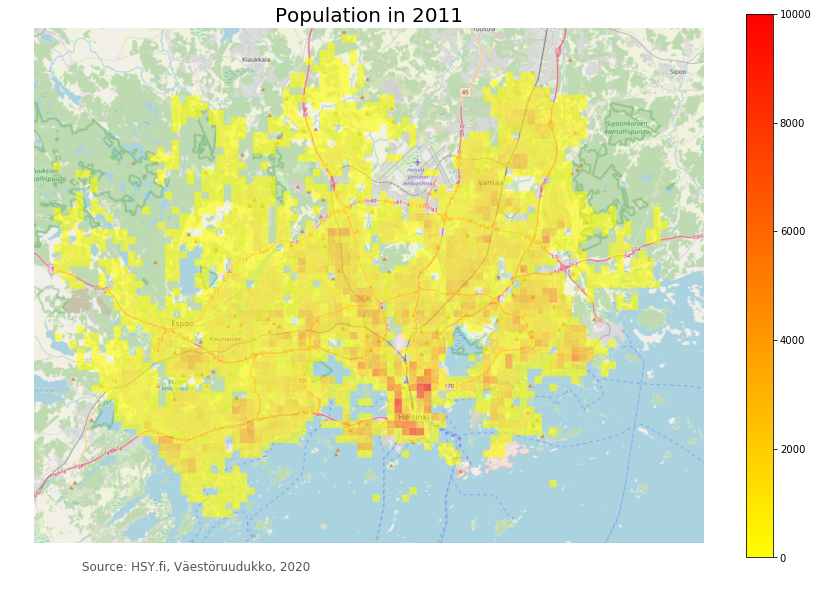

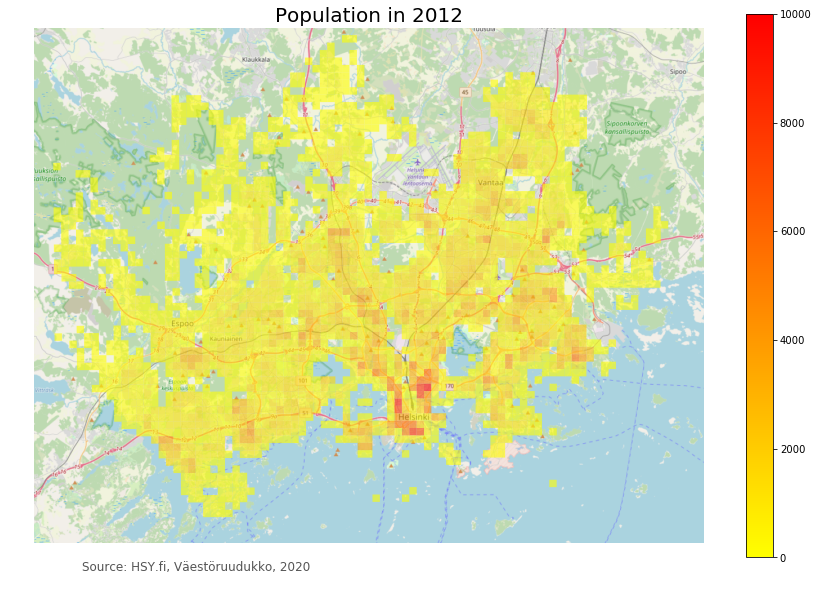

In [141]:
# Set coordinate reference system to mach background map
pop = gdf.to_crs(epsg=3857)

# Create and save figure of every year in the seleted list
for year in years:

    # set the range for the choropleth
    vmin, vmax = 0, max_population

    # Set column name which to visualize
    column_name = "pop"+str(year)

    # Define colour map (reverse autumn_r)
    cmap = matplotlib.cm.autumn
    cmap_reversed = matplotlib.cm.get_cmap('autumn_r')

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(15, 10))

    # Plot the data
    pop.plot(ax=ax, column=column_name, cmap=cmap_reversed, linewidth=0.6, alpha=0.6)

    # remove the axis
    ax.axis("off")

    # add a title
    ax.set_title("Population in " +str(year), fontdict={"fontsize": "20", "fontweight" : "3"})

    # Add source to the bottom left corner
    ax.annotate("Source: HSY.fi, Väestöruudukko, 2020",xy=(0.1, .08), xycoords="figure fraction", 
                horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap=cmap_reversed, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # empty array for the data range
    sm._A = []

    # Add the colorbar to the figure
    cbar = fig.colorbar(sm)

    # Add basemap with `ST_TONER` style
    ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

    # Crop the figure
    ax.set_xlim(2725000, 2816000)
    ax.set_ylim(8420000, 8490000)

    #saving our map as .png file.
    fig.savefig("docs/"+column_name+".png", dpi=100)